<a href="https://colab.research.google.com/github/Danboruya/data-mining-lecture-works/blob/master/data_analyze_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data-mining lecture works
In this notebook, we analyze the text data of movie review used in my graduation research.  
We show the visualization of word embeddings.

## Notebook Setup
Install the following necessary libraries.
* Tensorflow-gpu 2.0 bata
* h5py
* pyyaml
* hyperdash (For loging on mobile)

In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1
!pip install -q h5py pyyaml hyperdash

     |████████████████████████████████| 348.9MB 78kB/s 
     |████████████████████████████████| 501kB 43.8MB/s 
     |████████████████████████████████| 3.1MB 49.8MB/s 


Mount the my Google Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Get API key and setup hyperdash.

In [0]:
!hyperdash signup --github

VM specs

In [0]:
!cat '/proc/driver/nvidia/gpus/0000:00:04.0/information'
!echo ""
!lscpu
!echo ""
from fastai.utils.show_install import *
show_install()
!echo ""
!free -h

Model: 		 Tesla T4
IRQ:   		 11
GPU UUID: 	 GPU-5b41f9f8-94ea-ff56-7227-e1df38f1230d
Video BIOS: 	 90.04.21.00.01
Bus Type: 	 PCI
DMA Size: 	 47 bits
DMA Mask: 	 0x7fffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
Blacklisted:	 No

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht

## Import libraries

In [0]:
import re
import tensorflow as tf
import random
import numpy as np
import io
import os
import time
import matplotlib.pyplot as plt
from tensorboard.plugins import projector
from hyperdash import monitor_cell
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from hyperdash import Experiment

Set file path

In [0]:
# POS_DIR = './data/data/rt-polaritydata/rt-polarity-utf8.pos'
POS_DIR = '/gdrive/My Drive/Colab Notebooks/data/rt-polaritydata/rt-polarity-utf8.pos'

# NEG_DIR = './data/rt-polaritydata/rt-polarity-utf8.neg'
NEG_DIR = '/gdrive/My Drive/Colab Notebooks/data/rt-polaritydata/rt-polarity-utf8.neg'

# Log_DIR = './runs'
LOG_DIR = '/gdrive/My Drive/Colab Notebooks/runs'

## Load data

In [0]:
with open(POS_DIR, 'r') as f:
    raw_positive_sentences = f.readlines()
    raw_positive_sentences = [raw_sentence.replace(' \n', '') for raw_sentence in raw_positive_sentences]

In [0]:
with open(NEG_DIR, 'r') as f:
    raw_negative_sentences = f.readlines()
    raw_negative_sentences = [raw_sentence.replace(' \n', '') for raw_sentence in raw_negative_sentences]

## Pre-processings

In [0]:
def _string_cleaner(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [0]:
raw_positive_sentences = [_string_cleaner(sentence) for sentence in raw_positive_sentences]
raw_negative_sentences = [_string_cleaner(sentence) for sentence in raw_negative_sentences]

In [0]:
vocab = ['<unk>']

for sentence in raw_positive_sentences:
    for word in sentence.split(" "):
        if word not in vocab:
            vocab.append(word)

for sentence in raw_negative_sentences:
    for word in sentence.split(" "):
        if word not in vocab:
            vocab.append(word)

In [0]:
len(vocab)

18765

In [0]:
positive_sentences = []
negative_sentences = []
positive_labels = []
negative_labels = []
all_sentences = []
all_labels = []
sentence_length = 0

for sentence in raw_positive_sentences:
    s = []
    for word in sentence.split(" "):
        s.append(vocab.index(word))
    positive_sentences.append(s)
    positive_labels.append(1)
    all_sentences.append(s)
    all_labels.append(1)

for sentence in raw_negative_sentences:
    s = []
    for word in sentence.split(" "):
        s.append(vocab.index(word))
    negative_sentences.append(s)
    negative_labels.append(0)
    all_sentences.append(s)
    all_labels.append(0)
    
for sentence in positive_sentences:
    if sentence_length < len(sentence):
        sentence_length = len(sentence)
        
for sentence in negative_sentences:
    if sentence_length < len(sentence):
        sentence_length = len(sentence)

In [0]:
print(positive_sentences[0])
print(raw_positive_sentences[0])
print(sentence_length)

[1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 5, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
the rock is destined to be the 21st century 's new conan and that he 's going to make a splash even greater than arnold schwarzenegger , jean claud van damme or steven segal
56


In [0]:
def paddinger(sentence_list, sentence_length):
    for sentence in sentence_list:
        if len(sentence) != sentence_length:
            padding_list = [0 for _ in range(0, sentence_length - len(sentence))]
            sentence.extend(padding_list)
    return sentence_list

In [0]:
positive_sentences = paddinger(positive_sentences, sentence_length)
negative_sentences = paddinger(negative_sentences, sentence_length)
all_sentences = paddinger(all_sentences, sentence_length)

In [0]:
index_list = [i for i in range(0, len(all_sentences))]

random.seed(0)
random.shuffle(index_list)

shuffled_sentence = []
shuffled_labels = []
for index in index_list:
    shuffled_sentence.append(all_sentences[index])
    shuffled_labels.append(all_labels[index])

In [0]:
train_data = np.array(shuffled_sentence)
train_label = np.array(shuffled_labels)
print("data: {}, label: {}".format(len(train_data), len(train_label)))

data: 10662, label: 10662


Define the Hyperdash callback class

In [0]:
class Hyperdash(tf.keras.callbacks.Callback):
    def __init__(self, entries, exp):
        super(Hyperdash, self).__init__()
        self.entries = entries
        self.exp = exp

    def on_epoch_end(self, epoch, logs=None):
        for entry in self.entries:
            log = logs.get(entry)            
            if log is not None:
                self.exp.metric(entry, log)

## Model definitions

In [0]:
embedding_dim = 256
vocab_size = len(vocab)

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=sentence_length),
    layers.GRU(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
    layers.GRU(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
    layers.GRU(units=32, recurrent_dropout=0.2, dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 256)           4803840   
_________________________________________________________________
gru (GRU)                    (None, 56, 32)            27840     
_________________________________________________________________
gru_1 (GRU)                  (None, 56, 32)            6336      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,844,385
Trainable params: 4,844,385
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2 = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=sentence_length),
    layers.LSTM(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
    layers.LSTM(units=32, recurrent_dropout=0.2, dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

model2.summary()

## Experiment (1e-3)

In [0]:
timestamp = str(int(time.time()))
EXP_NAME = "GRU_3_layers_1e-3_dropout_" + timestamp
output_directory = os.path.abspath(os.path.join(os.path.curdir, LOG_DIR, 
                                                EXP_NAME))
checkpoint_path = output_directory + "/checkpoints/cp-{epoch:04d}.ckpt"

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory, histogram_freq=1,
                                    embeddings_freq=4)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

exp = Experiment(EXP_NAME, capture_io=False)
hd_callback = Hyperdash(["val_loss", "loss", "val_accuracy", "accuracy", 
                         "epoch"], exp)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, train_label, epochs=400, batch_size=256,
                    validation_split=0.01, verbose=2,
                    callbacks=[tb_cb, cp_callback, hd_callback])
model.save(output_directory + '/GRU_3_layers.h5')

str_ = '\n'.join(vocab)
with open(output_directory + '/vocab', 'w', encoding='utf-8') as f:
    f.write(str_)
    
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

out_v = io.open(output_directory + '/vecs_02.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory + '/meta_02.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.metadata_path = str(output_directory + '/meta_02.tsv')

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

exp.end()

## Experiment (1e-6)

In [0]:
del model
del history

embedding_dim = 256
vocab_size = len(vocab)

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=sentence_length),
    layers.GRU(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
    layers.GRU(units=32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2),
    layers.GRU(units=32, recurrent_dropout=0.2, dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

W0627 11:42:30.038343 139625308018560 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.
W0627 11:42:30.218487 139625308018560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10555 samples, validate on 107 samples
Epoch 1/400


W0627 11:42:41.322583 139625308018560 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (2.217476). Check your callbacks.
W0627 11:42:41.953591 139625308018560 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.657659). Check your callbacks.


| val_loss:   0.693334 |
| loss:   0.694029 |
| val_accuracy:   0.485981 |
| accuracy:   0.497395 |
10555/10555 - 36s - loss: 0.6940 - accuracy: 0.4974 - val_loss: 0.6933 - val_accuracy: 0.4860
Epoch 2/400
| val_loss:   0.693320 |
| loss:   0.694369 |
| val_accuracy:   0.485981 |
| accuracy:   0.488299 |
10555/10555 - 28s - loss: 0.6944 - accuracy: 0.4883 - val_loss: 0.6933 - val_accuracy: 0.4860
Epoch 3/400
| val_loss:   0.693312 |
| loss:   0.694220 |
| val_accuracy:   0.485981 |
| accuracy:   0.495026 |
10555/10555 - 27s - loss: 0.6942 - accuracy: 0.4950 - val_loss: 0.6933 - val_accuracy: 0.4860
Epoch 4/400

Epoch 00004: saving model to /gdrive/My Drive/Colab Notebooks/runs/GRU_3_layers_1e-6_dropout_1561635750/checkpoints/cp-0004.ckpt
| val_loss:   0.693299 |
| loss:   0.693268 |
| val_accuracy:   0.485981 |
| accuracy:   0.505732 |
10555/10555 - 27s - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6933 - val_accuracy: 0.4860
Epoch 5/400
| val_loss:   0.693291 |
| loss:   0.693796 |


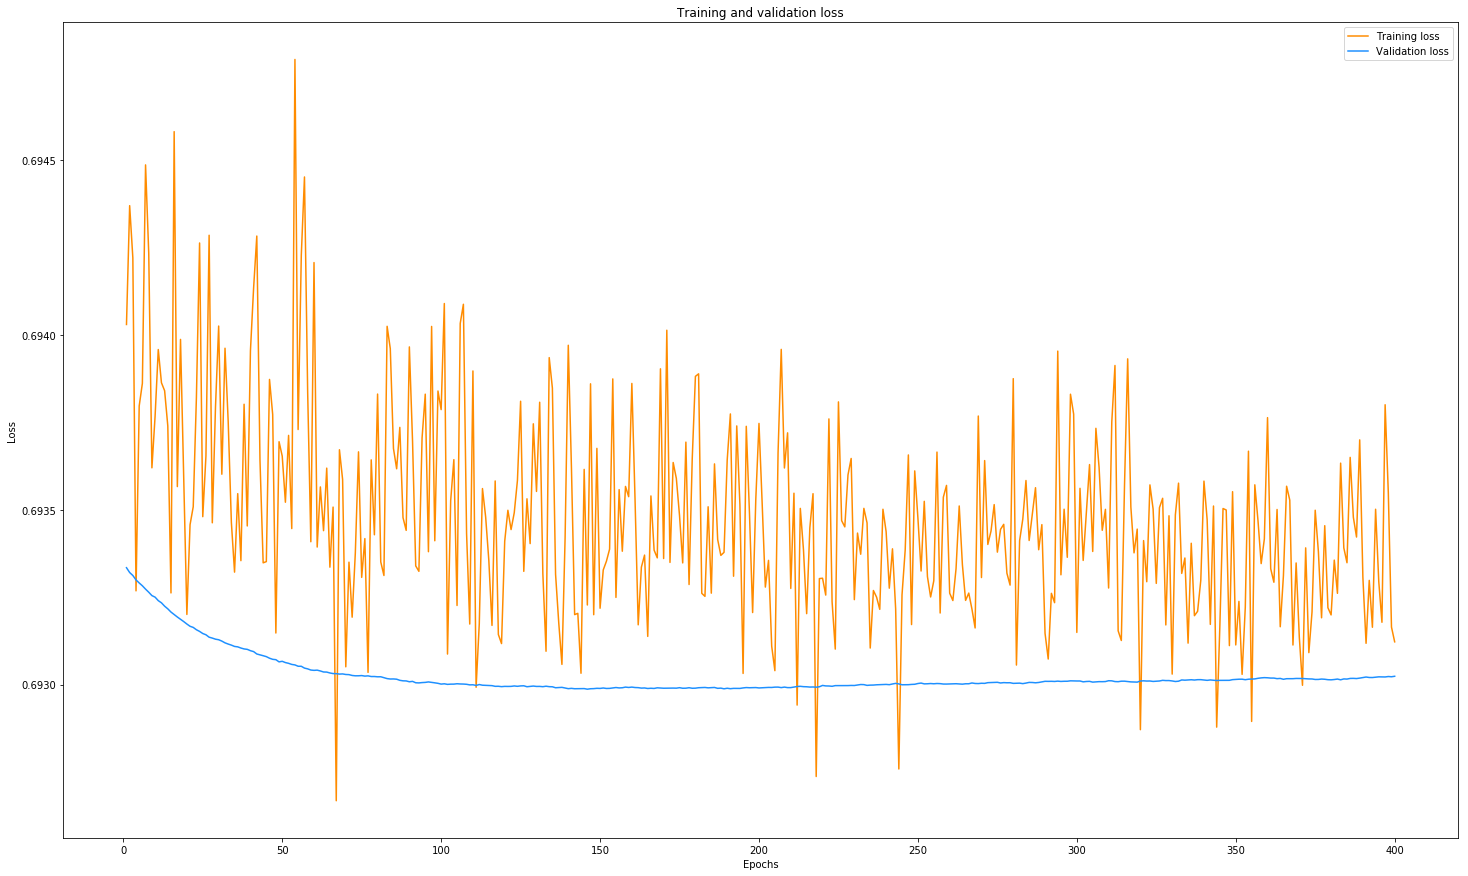

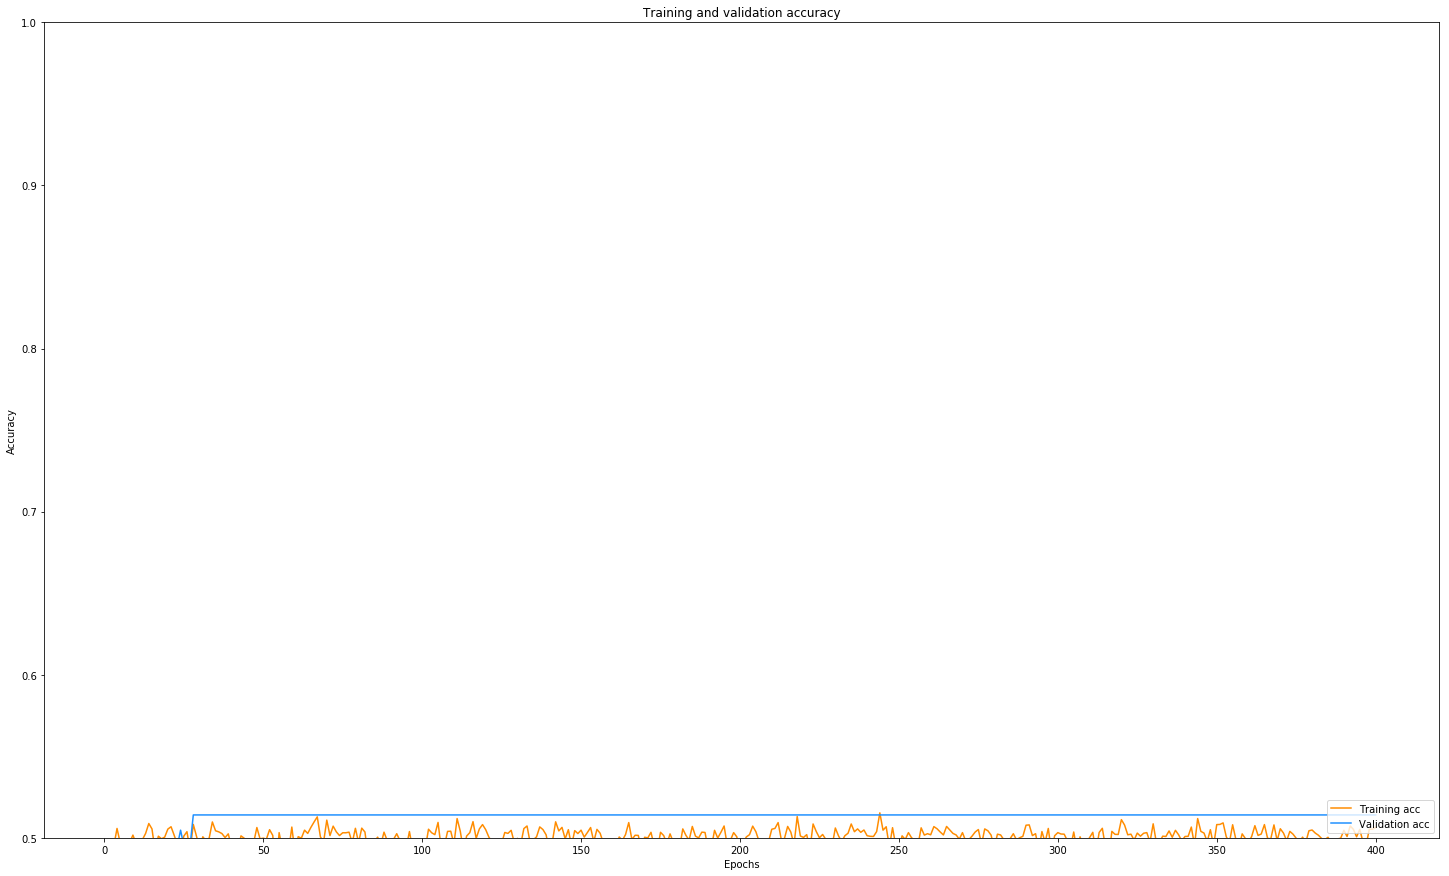

This run of GRU_3_layers_1e-6_dropout_1561635750 ran for 2:57:45 and logs are available locally at: /root/.hyperdash/logs/gru-3-layers-1e-6-dropout-1561635750/gru-3-layers-1e-6-dropout-1561635750_2019-06-27t11-42-30-042106.log


In [0]:
timestamp = str(int(time.time()))
EXP_NAME = "GRU_3_layers_1e-6_dropout_" + timestamp
output_directory = os.path.abspath(os.path.join(os.path.curdir, LOG_DIR, 
                                                EXP_NAME))
checkpoint_path = output_directory + "/checkpoints/cp-{epoch:04d}.ckpt"

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory, histogram_freq=1,
                                    embeddings_freq=4)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

exp = Experiment(EXP_NAME, capture_io=False)
hd_callback = Hyperdash(["val_loss", "loss", "val_accuracy", "accuracy", 
                         "epoch"], exp)

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, train_label, epochs=400, batch_size=256,
                    validation_split=0.01, verbose=2,
                    callbacks=[tb_cb, cp_callback, hd_callback])
model.save(output_directory + '/GRU_3_layers.h5')

str_ = '\n'.join(vocab)
with open(output_directory + '/vocab', 'w', encoding='utf-8') as f:
    f.write(str_)
    
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

out_v = io.open(output_directory + '/vecs_02.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory + '/meta_02.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.metadata_path = str(output_directory + '/meta_02.tsv')

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

exp.end()

## Experiment (1e-3 LSTM)

In [0]:
del history

In [0]:
timestamp = str(int(time.time()))
EXP_NAME = "LSTM_2_layers_1e-3_dropout_" + timestamp
output_directory = os.path.abspath(os.path.join(os.path.curdir, LOG_DIR, 
                                                EXP_NAME))
checkpoint_path = output_directory + "/checkpoints/cp-{epoch:04d}.ckpt"

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory, histogram_freq=1,
                                    embeddings_freq=4)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

exp = Experiment(EXP_NAME, capture_io=False)
hd_callback = Hyperdash(["val_loss", "loss", "val_accuracy", "accuracy", 
                         "epoch"], exp)

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(train_data, train_label, epochs=400, batch_size=256,
                    validation_split=0.01, verbose=2,
                    callbacks=[tb_cb, cp_callback, hd_callback])
model2.save(output_directory + '/GRU_3_layers.h5')

str_ = '\n'.join(vocab)
with open(output_directory + '/vocab', 'w', encoding='utf-8') as f:
    f.write(str_)
    
e = model2.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

out_v = io.open(output_directory + '/vecs_02.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory + '/meta_02.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.metadata_path = str(output_directory + '/meta_02.tsv')

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

exp.end()

## Experiment (1e-4 LSTM)

In [0]:
del model2
del history

model2 = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=sentence_length),
    layers.LSTM(units=32, return_sequences=True, dropout=0.2),
    layers.LSTM(units=32, dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

model2.summary()

In [0]:
timestamp = str(int(time.time()))
EXP_NAME = "LSTM_2_layers_1e-4_dropout_" + timestamp
output_directory = os.path.abspath(os.path.join(os.path.curdir, LOG_DIR, 
                                                EXP_NAME))
checkpoint_path = output_directory + "/checkpoints/cp-{epoch:04d}.ckpt"

tb_cb = keras.callbacks.TensorBoard(log_dir=output_directory, histogram_freq=1,
                                    embeddings_freq=4)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1,
                                              save_weights_only=True, period=4)

exp = Experiment(EXP_NAME, capture_io=False)
hd_callback = Hyperdash(["val_loss", "loss", "val_accuracy", "accuracy", 
                         "epoch"], exp)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model2.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(train_data, train_label, epochs=400, batch_size=256,
                    validation_split=0.01, verbose=2,
                    callbacks=[tb_cb, cp_callback, hd_callback])
model2.save(output_directory + '/GRU_3_layers.h5')

str_ = '\n'.join(vocab)
with open(output_directory + '/vocab', 'w', encoding='utf-8') as f:
    f.write(str_)
    
e = model2.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

out_v = io.open(output_directory + '/vecs_02.tsv', 'w', encoding='utf-8')
out_m = io.open(output_directory + '/meta_02.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
    word = vocab[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.metadata_path = str(output_directory + '/meta_02.tsv')

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(25, 15), facecolor="white")
plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

exp.end()

## Comment-outed cells

In [0]:
# history_dict = history.history

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.figure(figsize=(25, 15), facecolor="white")
# plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
# plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(25, 15), facecolor="white")
# plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
# plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.ylim((0.5,1))
# plt.show()

In [0]:
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)
# out_v = io.open(output_directory2 + '/vecs_02.tsv', 'w', encoding='utf-8')
# out_m = io.open(output_directory2 + '/meta_02.tsv', 'w', encoding='utf-8')
# for word_num in range(vocab_size):
#     word = vocab[word_num]
#     embeddings = weights[word_num]
#     out_m.write(word + "\n")
#     out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

Save the vocabrary to file.  
**Note:** Not *Binary* file.

In [0]:
# str_ = '\n'.join(vocab)
# with open(output_directory + '/vocab', 'w', encoding='utf-8') as f:
#     f.write(str_)

In [0]:
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)

(18765, 256)


In [0]:
# out_v = io.open(output_directory + '/vecs_02.tsv', 'w', encoding='utf-8')
# out_m = io.open(output_directory + '/meta_02.tsv', 'w', encoding='utf-8')
# for word_num in range(vocab_size):
#     word = vocab[word_num]
#     embeddings = weights[word_num]
#     out_m.write(word + "\n")
#     out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [0]:
# config = projector.ProjectorConfig()
# embedding = config.embeddings.add()
# embedding.metadata_path = str(output_directory + '/meta_02.tsv')

# writer = tf.summary.create_file_writer(output_directory)
# projector.visualize_embeddings(writer, config)

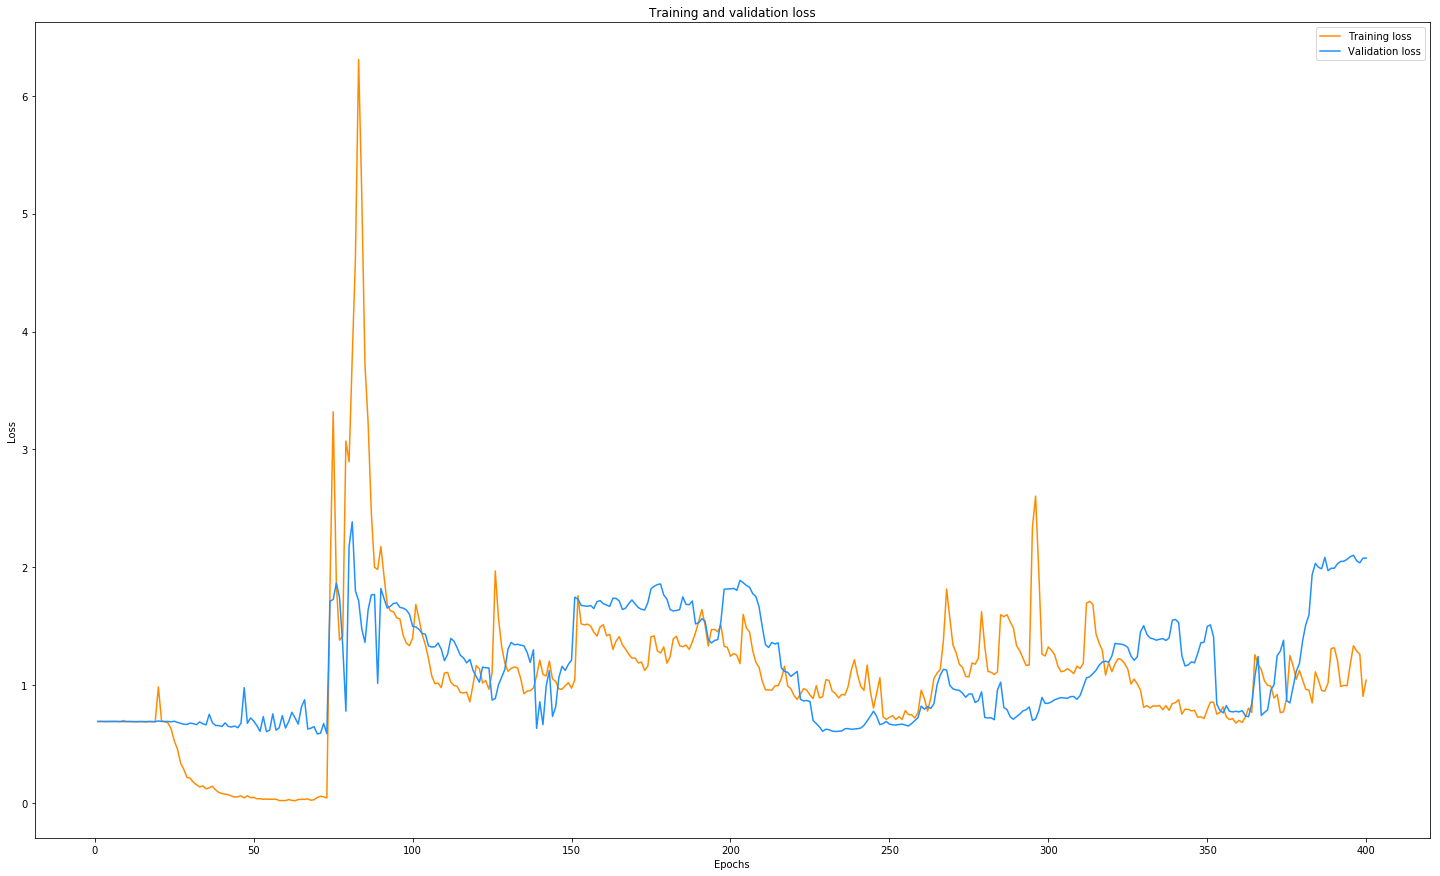

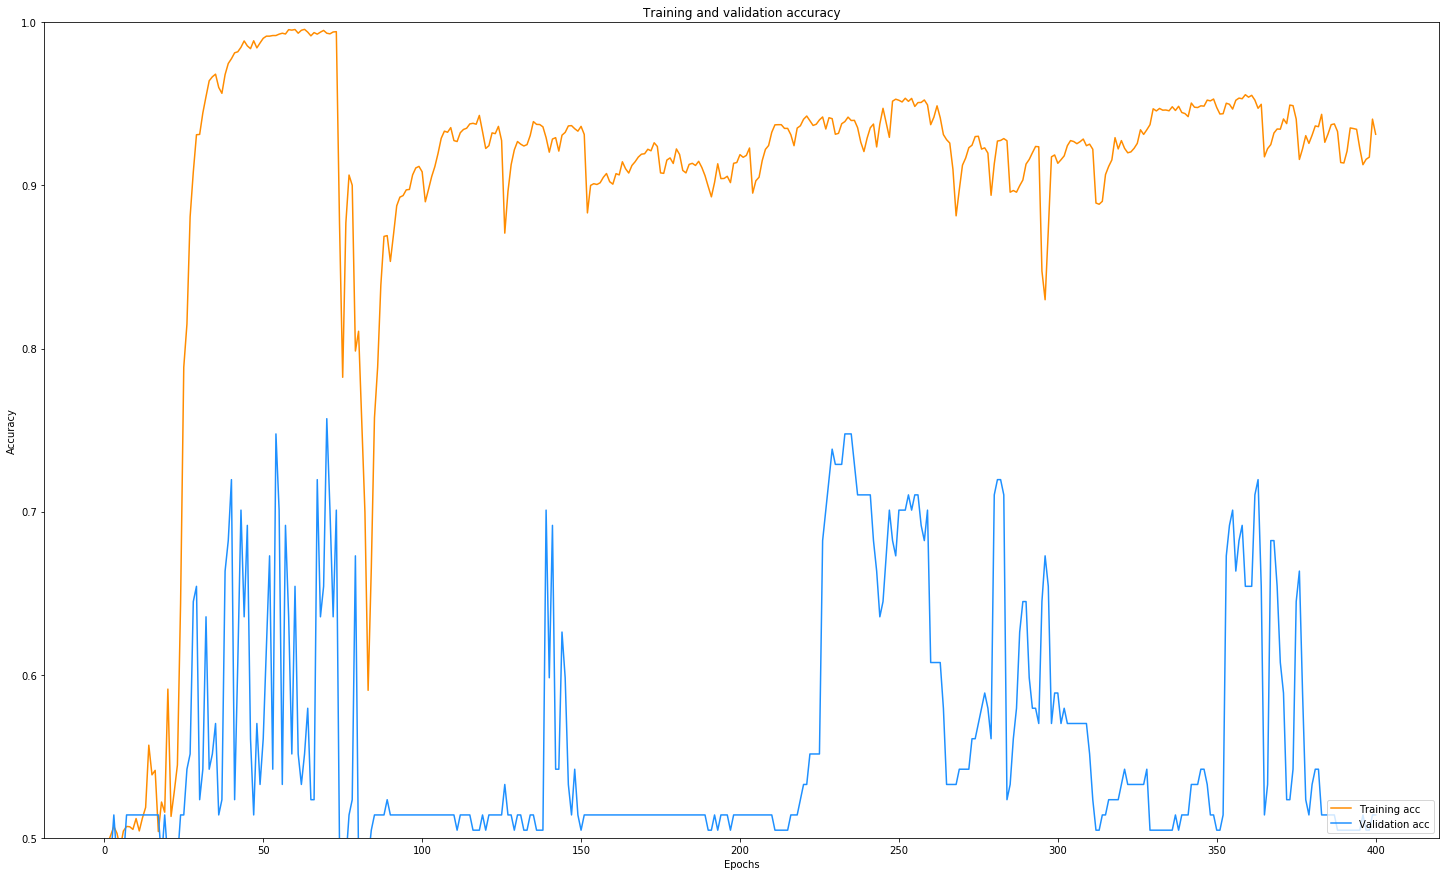

In [0]:
# history_dict = history.history

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.figure(figsize=(25, 15), facecolor="white")
# plt.plot(epochs, loss, 'b', label='Training loss', color="darkorange")
# plt.plot(epochs, val_loss, 'b', label='Validation loss', color="dodgerblue")
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(25, 15), facecolor="white")
# plt.plot(epochs, acc, 'b', label='Training acc', color="darkorange")
# plt.plot(epochs, val_acc, 'b', label='Validation acc', color="dodgerblue")
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.ylim((0.5,1))
# plt.show()